## Homework exercise 4
## Deadline: upload to Moodle by 19 April 18:00 h

__Suggestion: take this notebook and simply add your code and explanations.__

If you prefer to use .py files, you are expected to also include a PDF containing the output of your code and your explanations. Still, the code needs to be in a form that can be easily run on another computer.

Name 1: Dmitrii Klimov_11935751

Name 2: Dushan Trajkovski_01263345



The file that you upload should be named *Homework4_YourLastName_YourStudentID*.

Reminder: you are required to attend class on 20 April to earn points for this homework exercise unless you have a valid reason for your absence.

You are allowed to work on this exercise in groups of up to three students. If any part of the questions is unclear, please ask on the Moodle forum.

#### Momentum and trading volume
In this exercise, you are asked to obtain some stock market data and to compute and plot returns of certain investment strategies.

1. Please download data (over the whole available time period) for the stock symbols CSCO, GE, F, MSFT, AIG, JPM, AMGN, BRK-A, IBM, and AA for the period 1995 to 2020. Plot the cumulative returns of all of these stocks in a single figure.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
%matplotlib inline

In [54]:
start = pd.to_datetime("1995")
end = pd.to_datetime("2020")
assets = ['CSCO', 'GE', 'F', 'MSFT', 'AIG', 'JPM', 'AMGN', 'BRK-A', 'IBM', 'AA']
data = web.DataReader(assets,'yahoo',start,end)

data = data.sort_index(axis = 1)
data.head()

Attributes  Adj Close                        ...      Volume                       
Symbols            AA         AIG      AMGN  ...         IBM        JPM        MSFT
Date                                         ...                                   
1995-01-03  17.581966  200.543488  5.761800  ...   4671600.0  2048700.0  39545600.0
1995-01-04  17.614931  198.247299  5.792712  ...   7978800.0  2487300.0  51611200.0
1995-01-05  17.532507  197.992081  5.934903  ...   9083600.0  3537900.0  39824000.0
1995-01-06  18.010592  197.992081  5.798893  ...  12162000.0  2355300.0  46681600.0
1995-01-09  18.200176  198.247299  5.724709  ...   6852000.0  1068900.0  46000000.0

[5 rows x 60 columns]

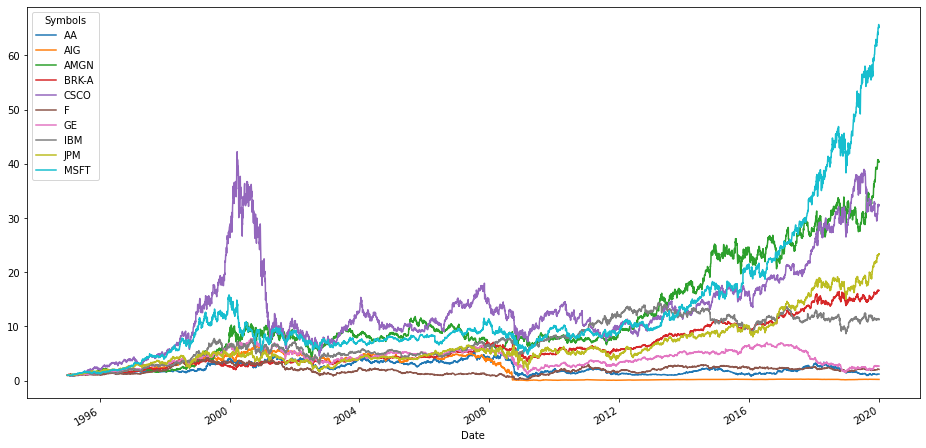

In [55]:
(data['Adj Close'].pct_change()+1).cumprod().plot(figsize=(16,8))

2. The goal now is to first consider returns of simple momentum/reversal investment strategies. A momentaum (reversal) strategy invests in recent winners (losers) and takes a short position in recent losers (winners). Assume that whenever you change your portfolio (i.e. at the opening price on every day, week, or month), you invest the same amount in each position, and compute the returns of strategies that

* every day take a long position in the previous day's 5 worst performing stocks and a short position in the previous day's 5 best performing stocks.

* every week take a long position in the previous week's 5 worst performing stocks and a short position in the previous week's 5 best performing stocks.

* every month __t__ take a long position in the 5 stocks performing best during the months __t-6__ to __t-2__ and a short position in the 5 stocks performing worst during that period.

Plot the cumulative returns of each of these strategies and provide descriptive statistics of the one-period returns.

In [52]:
class Portfolio:
    #store the main values here
    def __init__(self, data, assets, initial_capital):
        self.data = data.copy()
        self.assets = assets    
        self.initial_capital = initial_capital

    def strategy(self,strategy_type,volume=False):
        '''
        the main method to perform the backtest. It includes data preparation, signal creation, trading and portfolio creation
        ''' 

        self.strategy_type = strategy_type
        self.volume = volume
        #prepare the data, resample it for different timeframes
        self.returns, self.returns_resample = self.data_preparation(self.data,self.strategy_type,self.volume)
        #creating to dataframes, first for the signals, second is used for performance calculation
        self.order_dir, self.order_dir_f = self.trades(self.returns,self.returns_resample,self.strategy_type,self.volume)
        self.port_holdings = self.returns.copy()
        self.port_holdings['Value'] = 0.0
        for i in range(len(self.returns)):
          day = self.returns.index[i]
          #warming-up period until we recieve the first signal
          if day < self.order_dir.index[0]:
            weights = self.initial_capital/10
            for asset in self.assets:
              self.port_holdings[asset].iloc[i] = weights
              self.port_holdings['Value'].iloc[i] = self.initial_capital  
          else:
            #if today is a rebalancing day, we initialize new assets allocation
            if day in self.order_dir.index:
              weights = self.port_holdings['Value'].iloc[i-1]/10
              for asset in self.assets:
                self.port_holdings[asset].loc[day] =  weights * (self.order_dir_f[asset].loc[day]*self.returns[asset].iloc[i]+1)
                self.port_holdings['Value'].loc[day] = self.port_holdings[assets].loc[day].sum()
            # else, we calculate portfolio performance
            else:
              for asset in self.assets:
                self.port_holdings[asset].iloc[i] = self.port_holdings[asset].iloc[i-1] * (self.order_dir_f[asset].loc[day]*self.returns[asset].loc[day]+1)
                self.port_holdings['Value'].loc[day] = self.port_holdings[assets].loc[day].sum()
      
        self.port_holdings['Daily Returns'] = self.port_holdings['Value'].pct_change().dropna()


    def data_preparation(self,data,strategy_type,volume = False):
      '''
      method for preparing the data for the signal creating func
      '''

      if volume: # if we need to perform the volume related strategy
        self.volume_daily = self.data['Volume'].copy()
        if self.strategy_type == 'daily':
          self.returns = self.data['Adj Close'].pct_change().dropna()
          self.returns_resample = self.volume_daily.rolling(window=10).sum()
          self.returns_resample = (1 + (self.volume_daily/self.returns_resample.shift(10))).dropna()
          self.returns_resample = self.returns_resample.pct_change().dropna()
          return self.returns, self.returns_resample
        elif self.strategy_type == 'weekly':
          self.returns = self.data['Adj Close'].pct_change().dropna()
          self.volume_weekly = self.volume_daily.resample('W-FRI').sum()
          self.returns_resample = self.volume_weekly.rolling(window=4).sum()
          self.returns_resample = (1 + (self.volume_weekly/self.returns_resample.shift(4))).dropna()
          self.returns_resample = self.returns_resample.pct_change().dropna()
          return self.returns, self.returns_resample
        elif self.strategy_type == 'monthly':
          self.returns = self.data['Adj Close'].pct_change().dropna()
          self.volume_monthly = self.volume_daily.resample('BM').sum()
          self.volume_monthly10 = self.volume_monthly.rolling(window=10).sum()
          self.volume_monthly_t2_t6 = self.volume_monthly.rolling(window=4).sum()
          self.returns_resample = (1 + (self.volume_monthly_t2_t6.shift(2)/self.volume_monthly10)).dropna()
          self.returns_resample = self.returns_resample.pct_change().dropna()
          return self.returns, self.returns_resample
        else:
          print('please, put an existing strategy name')
          return None
      
      else: #if there is no volume involved
        if self.strategy_type == 'daily':
          self.returns = self.data['Adj Close'].pct_change().dropna()
          self.returns_resample = self.returns.copy()
          return self.returns, self.returns_resample
        elif self.strategy_type == 'weekly':
          self.returns = self.data['Adj Close'].pct_change().dropna()
          self.returns_resample = self.data.resample('W-FRI').last().pct_change().dropna()
          return self.returns, self.returns_resample
        elif self.strategy_type == 'monthly':
          self.returns = self.data['Adj Close'].pct_change().dropna()
          self.returns_resample = self.data.resample('BM').last().pct_change().dropna()
          return self.returns, self.returns_resample
        else:
          print('please, put an existing strategy name')
          return None       




    def trades(self, returns, returns_resample, strategy_type,volume):
      '''
      method which creates a dataframe with all directions we need to perform our backtest 
      '''
      self.strategy_type = strategy_type
      if self.strategy_type == 'daily':  
        self.order_dir = self.order_direction(self.returns_resample)
        self.order_dir = self.order_dir.iloc[1:]
      elif self.strategy_type == 'weekly':
        if volume:
          self.order_dir = self.order_direction(self.returns_resample)
        else:
          self.order_dir = self.order_direction(self.returns_resample['Adj Close'])
        self.order_dir = self.order_dir.iloc[1:]
      elif self.strategy_type == 'monthly':
        if volume:
          self.order_dir = self.order_direction_m(self.returns_resample)
        else:
          self.order_dir = self.order_direction_m(self.returns_resample['Adj Close'])
        self.order_dir = self.order_dir.iloc[6:]
      else:
        print('please, put an existing strategy name')
        return None
      self.order_dir_f = pd.DataFrame(np.nan,index=self.returns.index,columns=self.returns.columns)
      self.order_dir_f[self.order_dir_f.isnull()] = self.order_dir
      self.order_dir_f = self.order_dir_f.fillna(method='ffill').dropna()


      return self.order_dir, self.order_dir_f
      
    def order_direction(self, returns):
      '''
      here we create a df with our trade directions, -1 for shorts, 1 for long positions. This will be used in trades method
      '''
      self.strat = returns.copy()
      for i in range(1,len(self.strat)):
        longs = self.returns.iloc[i-1].sort_values().index[:5].tolist()
        for asset in self.assets:
          if asset in longs:
            self.strat[asset].iloc[i] = -1
          else:
            self.strat[asset].iloc[i] = 1
      return self.strat       

    def order_direction_m(self, returns): # same as the previous method but for monthly rebalancing
      self.strat = returns.copy()
      for i in range(6,len(self.strat)):
        longs = ((self.returns.iloc[i-6:i-2]+1).cumprod().iloc[-1]-1).sort_values().index[:5].tolist()
        for asset in self.assets:
          if asset in longs:
            self.strat[asset].iloc[i] = 1
          else:
            self.strat[asset].iloc[i] = -1
      #strat = strat.iloc[1:]
      return self.strat


    def get_annualized_return(self):
        return round((self.port_holdings['Value'][-1]/self.initial_capital)**(365/len(self.data))-1,2)

    def get_annualized_volatility(self):
        return self.port_holdings['Daily Returns'].std()*np.sqrt(252)

    def get_sharpe_ratio(self):
        return round(self.get_annualized_return() / self.get_annualized_volatility(),2)
            
    def get_max_drawdown(self):
        cum_ret = self.port_holdings['Value']/self.initial_capital
        roll_max = cum_ret.cummax()
        daily_drawdown = cum_ret/roll_max -1.0
        max_daily_drawdown = daily_drawdown.cummin()
        return round(max_daily_drawdown[-1],2)
    
    def get_max_underwater(self):
        cum_ret = self.port_holdings['Value']/self.initial_capital
        self.port_holdings['cummax'] = cum_ret.cummax()
        self.port_holdings['underwater'] = cum_ret < self.port_holdings['cummax']
        x = 0
        mx = 0
        for i in range(len(self.port_holdings)):
          if self.port_holdings['underwater'][i]:
            x +=1
            if x > mx:
              mx = x
          else:
            x = 0
        return mx
            
    
    def print_performance(self):
        print(
         "\nPerformance for strategy {strat}".format(strat=self.strategy_type)+
         "\nTotal return: "+str(round(self.port_holdings['Value'][-1]/self.initial_capital-1,2))+
         "\nAnnualized return: "+str(self.get_annualized_return())+
         "\nAnnualized Volatility: "+str(round(self.get_annualized_volatility(),2))+
         "\nSharpe Ratio: "+str(self.get_sharpe_ratio())+
         "\nMax Drawdown: "+str(self.get_max_drawdown())+
         "\nMax Underwater: "+str(self.get_max_underwater()))
        plt.figure(figsize =(12,8))
        plt.plot(self.port_holdings['Value'])
        plt.ylabel('Total performance')
        plt.title("Performance for strategy {strat}".format(strat=self.strategy_type))
        plt.show()
        #self.data['Equity Curve'].plot(figsize=(16,8),
        #                               title = 'Performance for strategy {strat} and ticker {tck}'.format(strat=self.strategy_type,tck=self.ticker))
        

In [19]:
assets

['CSCO', 'GE', 'F', 'MSFT', 'AIG', 'JPM', 'AMGN', 'BRK-A', 'IBM', 'AA']


Performance for strategy daily
Total return: -0.33
Annualized return: -0.02
Annualized Volatility: 0.1
Sharpe Ratio: -0.2
Max Drawdown: -0.63
Max Underwater: 6273


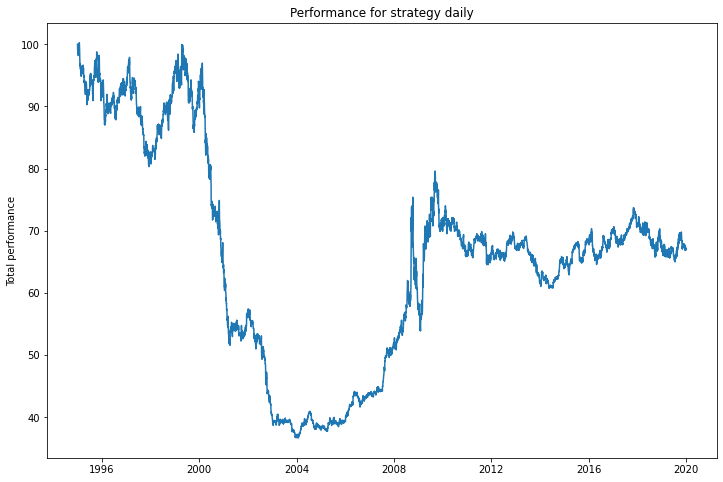


Performance for strategy weekly
Total return: 0.46
Annualized return: 0.02
Annualized Volatility: 0.1
Sharpe Ratio: 0.21
Max Drawdown: -0.31
Max Underwater: 2215


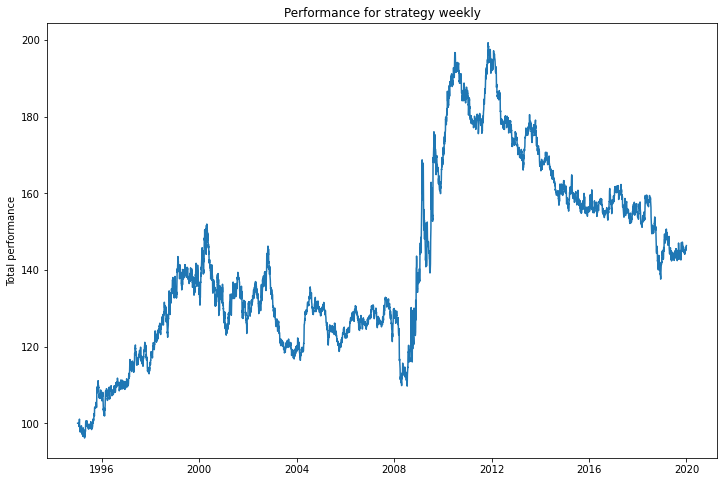


Performance for strategy monthly
Total return: 0.03
Annualized return: 0.0
Annualized Volatility: 0.11
Sharpe Ratio: 0.0
Max Drawdown: -0.47
Max Underwater: 2841


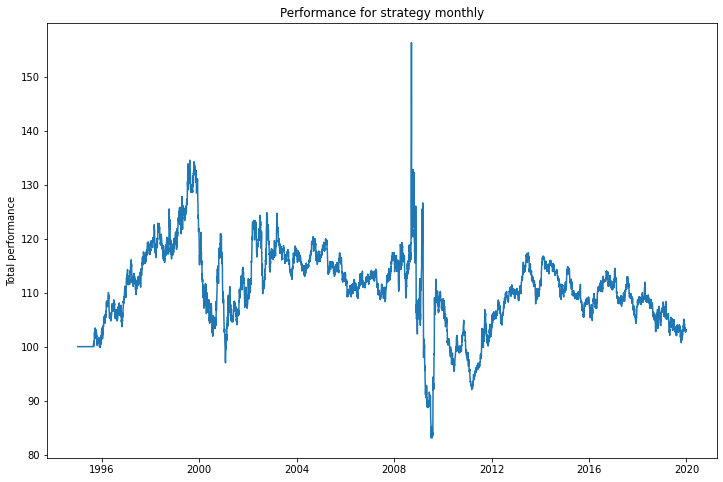

CPU times: user 5min 31s, sys: 4.11 s, total: 5min 35s
Wall time: 5min 34s


In [20]:
%%time
strategies = ['daily','weekly','monthly']
for strat in strategies:
  port = Portfolio(data,assets,100)
  port.strategy(strat)
  port.print_performance()

3. We next consider a refinement of the above strategies that takes the trading volume in each stock, relative to the stocks' own historical volume, into account. To prepare for this step, compute for each stock

* every day the trading volume (in shares) on that day relative to the trading volume on the previous 10 trading days
* every week the trading volume (in shares) in that week relative to the trading volume during the previous 4 weeks
* every month the trading volume (in shares) during the months __t-6__ to __t-2__ relative to the trading volume in the previous 10 months

Next, adjust the investment strategies from 2. such that you always take long and short positions, respectively, in the 2 among the 5 stocks that had the highest recent trading volume (relative to their past volumes, computed as above).

Plot the cumulative returns of each of these strategies and provide descriptive statistics of the one-period returns.


Performance for strategy daily
Total return: -0.17
Annualized return: -0.01
Annualized Volatility: 0.1
Sharpe Ratio: -0.1
Max Drawdown: -0.51
Max Underwater: 5875


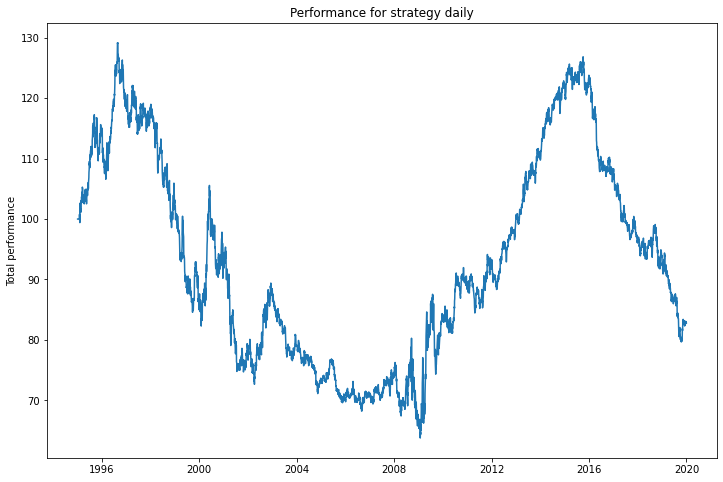


Performance for strategy weekly
Total return: -0.47
Annualized return: -0.04
Annualized Volatility: 0.1
Sharpe Ratio: -0.4
Max Drawdown: -0.67
Max Underwater: 6239


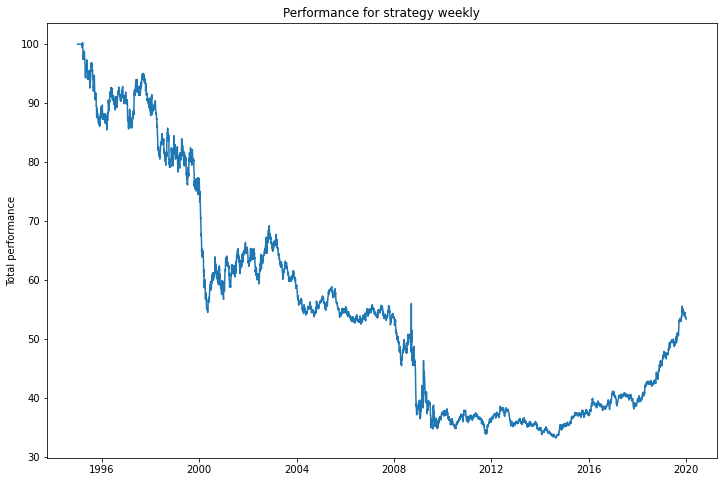


Performance for strategy monthly
Total return: -0.14
Annualized return: -0.01
Annualized Volatility: 0.1
Sharpe Ratio: -0.1
Max Drawdown: -0.54
Max Underwater: 4934


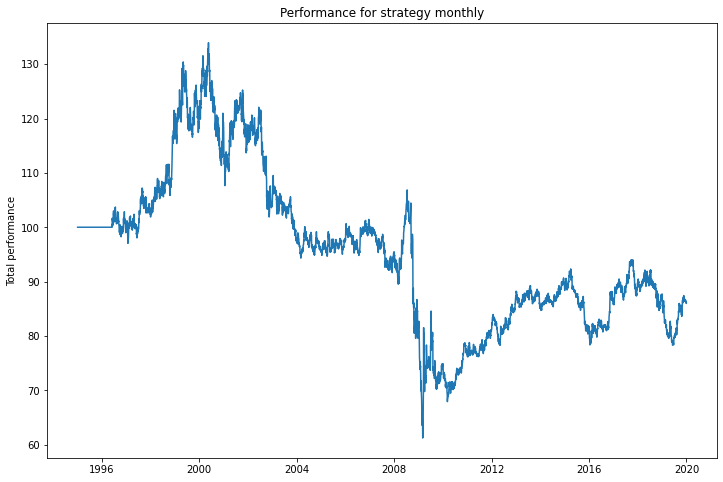

CPU times: user 5min 28s, sys: 4.17 s, total: 5min 33s
Wall time: 5min 32s


In [48]:
%%time
strategies = ['daily','weekly','monthly']
for strat in strategies:
  port = Portfolio(data,assets,100)
  port.strategy(strat,volume=True)
  port.print_performance()